Seed set to 42



Per-class report (lesion-level):
                              precision    recall  f1-score   support

        Basal cell carcinoma      0.707     0.541     0.613       196
              Dermatofibroma      0.231     0.750     0.353         8
         Melanoma metastasis      0.443     0.794     0.568        34
               Melanoma, NOS      0.629     0.423     0.506       104
                       Nevus      0.803     0.684     0.738       256
                        Scar      0.111     0.333     0.167        15
        Seborrheic keratosis      0.354     0.288     0.318        59
               Solar lentigo      0.188     0.500     0.273        12
  Solar or actinic keratosis      0.259     0.298     0.277        47
Squamous cell carcinoma, NOS      0.235     0.500     0.320        24

                    accuracy                          0.546       755
                   macro avg      0.396     0.511     0.413       755
                weighted avg      0.621     0.546     

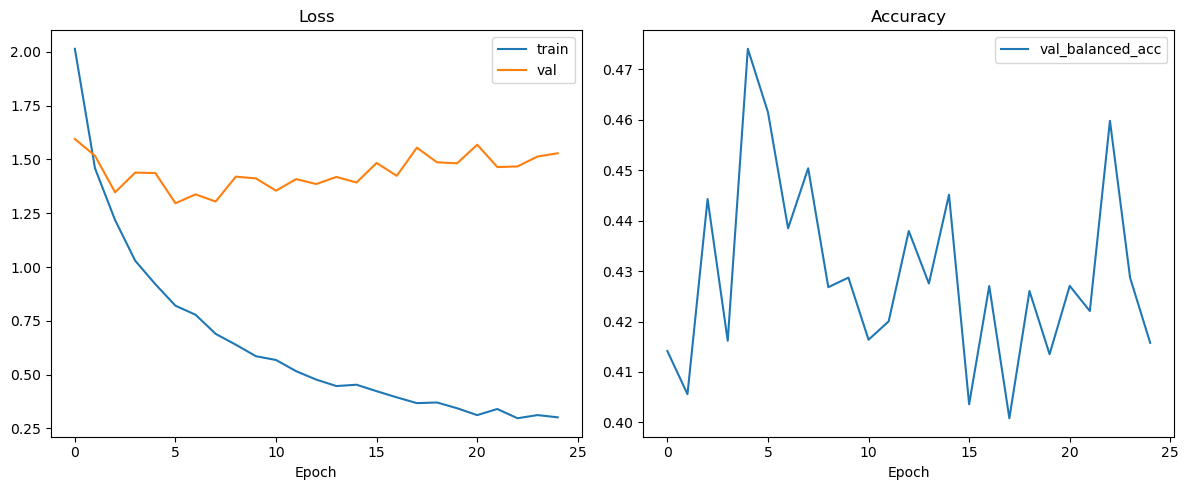

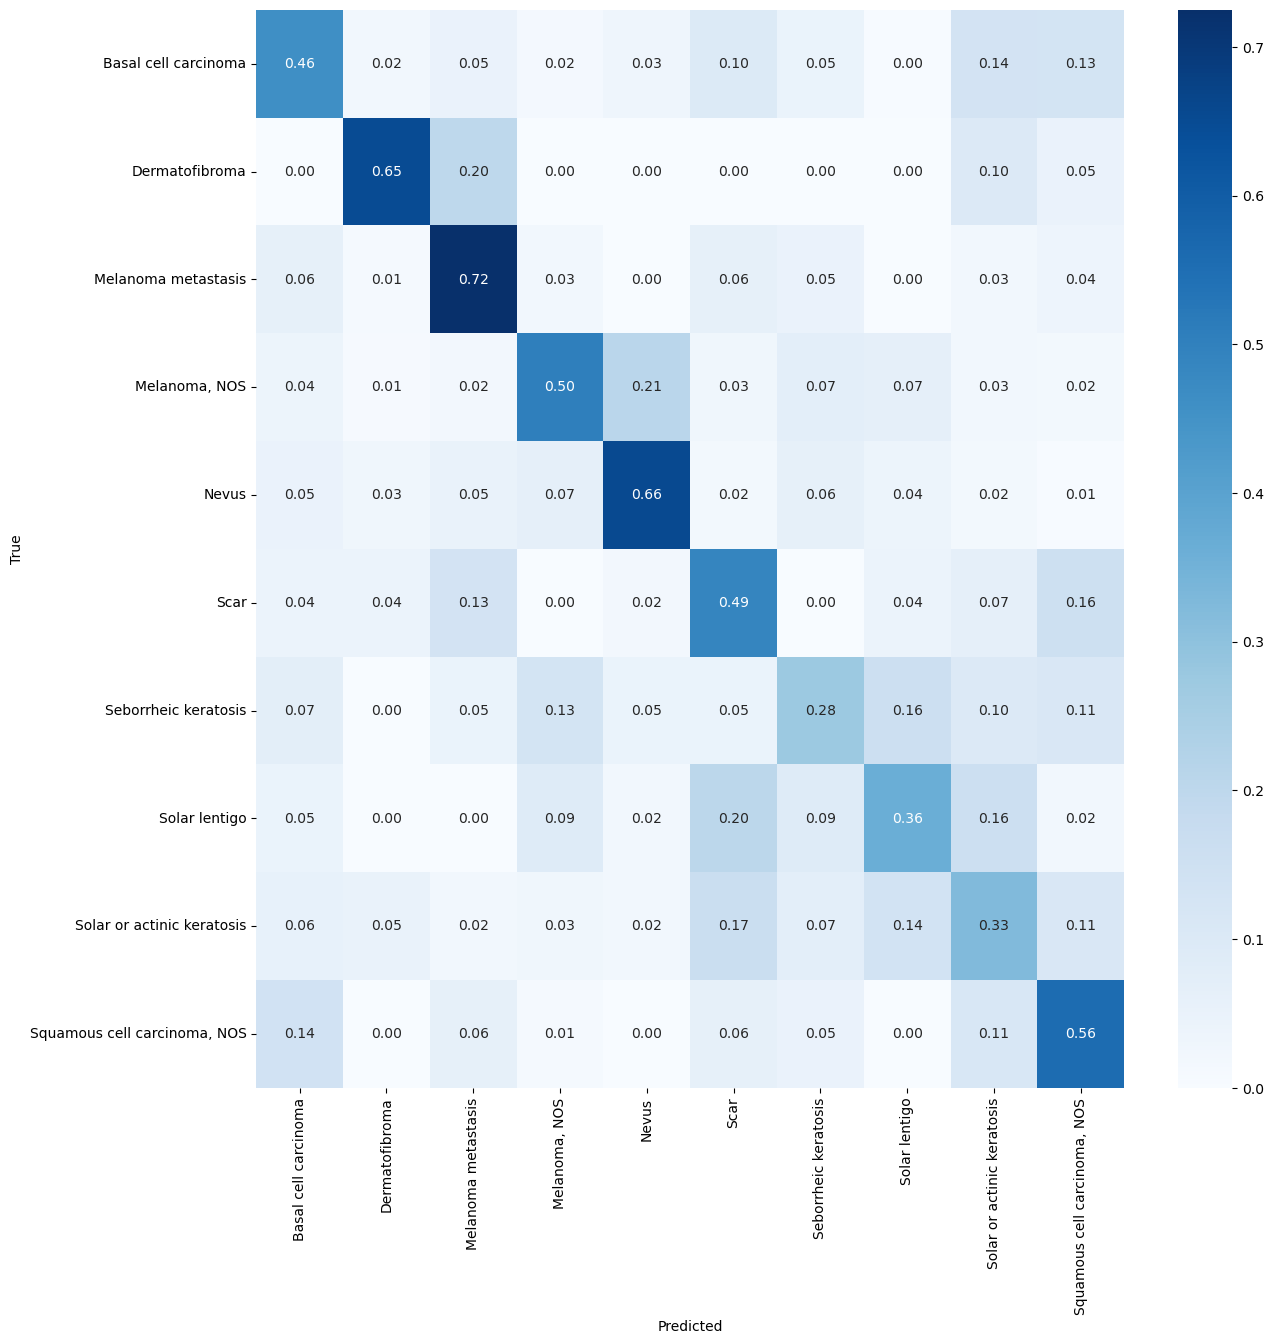

In [1]:
# classifier/eval.py

from pathlib import Path
import pytorch_lightning as pl
import torch

import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score

from config import *
from data.splits import create_splits
from data.transforms import get_transforms
from data.datamodule import ImageDataModule
from models.efficientnet import EfficientNetLit
from utils.plots import plot_metrics, plot_confusion_matrix
from utils.seed import set_seed
from sklearn.metrics import classification_report



def main():
    set_seed(SEED)

    LOG_DIR = Path("logs/efficientnet/version_56")
    CKPT_PATH = LOG_DIR / "checkpoints"
    CKPT_PATH = list(CKPT_PATH.glob("*.ckpt"))[0]

    # 3. данные (те же split'ы!)
    train_df, val_df, test_df, classes = create_splits(
        metadata_csv= METADATA_DIR,
        images_dir= METADATA_DIR,
        seed=SEED,
        test_size=TEST_SIZE,
        val_size=VAL_SIZE,
    )

    train_tfms, val_tfms = get_transforms()

    datamodule = ImageDataModule(
        train_df,
        val_df,
        test_df,
        train_tfms,
        val_tfms,
        BATCH_SIZE,
        NUM_WORKERS,
    )

    # 4. загрузка модели
    model = EfficientNetLit.load_from_checkpoint(
        CKPT_PATH,
        num_classes=len(classes),
        lr=LR,
        strict=False,
    )


    model.eval()
    preds, targets = [], []

    datamodule.setup(stage="test") 
    
    for x, y in datamodule.test_dataloader():
        x, y = x.to(model.device), y.to(model.device)  # если есть GPU
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(1)
        preds.extend(pred.cpu().numpy())
        targets.extend(y.cpu().numpy())

    # 1. Берём test_df, который соответствует test_dataloader
    df = test_df.copy().reset_index(drop=True)
    
    # 2. Добавляем предсказания модели
    df["pred"] = preds
    
    # 3. Агрегация по lesion_id (majority vote)
    lesion_preds = (
        df.groupby("lesion_id")["pred"]
          .agg(lambda x: np.bincount(x).argmax())
    )
    
    lesion_targets = (
        df.groupby("lesion_id")["label"]
          .first()
    )

    print("\nPer-class report (lesion-level):")
    print(
        classification_report(
            lesion_targets,
            lesion_preds,
            target_names=classes,
            digits=3,
            zero_division=0,
        )
    )

    
    # 4. Метрика как в статье
    bal_acc = balanced_accuracy_score(lesion_targets, lesion_preds)
    
    print("Lesion-level balanced accuracy:", bal_acc)

    OUTPUT_DIR = LOG_DIR / "figures"
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

    print("\nPer-class report (image-level):")
    print(
        classification_report(
            targets,
            preds,
            target_names=classes,
            digits=3,
            zero_division=0,
        )
    )

    
    plot_metrics(LOG_DIR, save_path=OUTPUT_DIR / "metrics.pdf")
    plot_confusion_matrix(targets, preds, classes, save_path=OUTPUT_DIR / "confusion_matrix.pdf")
    

if __name__ == "__main__":
    main()


In [2]:
# classifier/inspect_transforms.py

import os
import torch
import matplotlib.pyplot as plt
from PIL import Image

from config import *
from data.splits import create_splits
from data.transforms import get_transforms
from utils.seed import set_seed


def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean


def find_image_path(row, images_dir):
    """
    Автоматически находит файл изображения на диске,
    даже если в df лежит только image_id
    """
    exts = [".jpg", ".png", ".jpeg"]

    for col in row.index:
        val = row[col]

        if not isinstance(val, str):
            continue

        #  если в df уже полный путь
        if os.path.isfile(val):
            return val

        #  если это image_id -> пробуем с расширениями
        for ext in exts:
            candidate = os.path.join(images_dir, val + ext)
            if os.path.isfile(candidate):
                return candidate

        #  если лежит в поддиректории images/
        for ext in exts:
            candidate = os.path.join(images_dir, "images", val + ext)
            if os.path.isfile(candidate):
                return candidate

    raise FileNotFoundError(
        f"Не удалось найти файл изображения для строки:\n{row}"
    )



def main():
    set_seed(SEED)

    train_df, _, _, classes = create_splits(
        metadata_csv=METADATA_DIR,
        images_dir=METADATA_DIR,
        seed=SEED,
        test_size=TEST_SIZE,
        val_size=VAL_SIZE,
    )

    train_tfms, _, _ = get_transforms()

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    # выбираем конкретный индекс
    idx = 42         
    row = train_df.iloc[idx]

    img_path = find_image_path(row, METADATA_DIR)
    label = row["label"]

    img_pil = Image.open(img_path).convert("RGB")

    # ---------- ВИЗУАЛИЗАЦИЯ ----------
    plt.figure(figsize=(16, 8))

    # ОРИГИНАЛ
    plt.subplot(3, 5, 1)
    plt.imshow(img_pil)
    plt.title("ORIGINAL")
    plt.axis("off")

    #  АУГМЕНТАЦИИ
    for i in range(10):
        img = train_tfms(img_pil)
        img = denormalize(img, mean, std)
        img = img.permute(1, 2, 0).clamp(0, 1)

        plt.subplot(3, 5, i + 6)
        plt.imshow(img)
        plt.title(f"AUG {i+1}")
        plt.axis("off")

    plt.suptitle(
        f"idx={idx} | label={classes[label]}",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Seed set to 42


ValueError: not enough values to unpack (expected 3, got 2)